# Notebook for analysing datasets
In order to classfiy the accuracy metrics, one can take a further look into the data distribtuion of a local dataset an dsee how the trajectories are spread across time and space.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2024-09-30 15:03:59.408061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 15:04:00.576769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline

In [6]:
train_dataset = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test"
    )

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14913208657754708145


In [7]:
"""
Loads the trajectories with positions only from the datasets (are assumed to have positions and poses as trajectories)
"""

def get_traj_crowdbot(trajectory1, trajectory2):
    """
    Gets first and third component of 3D coordinate since that corresponds to the ground plane axis of the crowdbot dataset
    """
    return tf.gather(trajectory1, [0,2], axis=2)

def get_traj(trajectory1, trajectory2):
    """
    Gets the first two components of the 3D coordinate to get the gorund plane movement
    """
    return tf.gather(trajectory1, [0,1], axis=2)

def z_score_normalization(trajectory):
    """
    Apply z-score normalization to a trajectory.
    """
    # Calculate mean and standard deviation along the timestep axis
    mean = tf.reduce_mean(trajectory, axis=0)
    std = tf.math.reduce_std(trajectory, axis=0)
    
    # Apply z-score normalization
    normalized_trajectory = (trajectory - mean) / std
    return normalized_trajectory


train_dataset = train_dataset.map(get_traj_crowdbot)
# optionally apply normalisation
#test_dataset = test_dataset.map(z_score_normalization)

In [8]:
def prepare_data_2d(dataset, history_steps, predict_steps):
    """ 
    Split the datasets in history sequence (length 5), prediction sequence (length 10) and full sequence 
    and convert each list to a numpy array for easier data analysis

    :param dataset: dataset with the entry being of shape (batch_size, sequence_length, 2)
    :param history_steps: amount of steps that are given as historical information
    :param predict_steps: amount of steps that shoudl be predicted

    :returns tuple of all three lists
    """
    X1_list, y_list, full_list = [], [], []
    for batch_x1 in dataset:
        batch_x1 = batch_x1.numpy()  # Convert Tensor to NumPy array
        batch_size = batch_x1.shape[0]
        for i in range(batch_size):
            sequence = batch_x1[i]
            
            # Take only the first two dimensions (2D positions)
            sequence = sequence[:, :2]
            
            if len(sequence) >= history_steps + predict_steps:
                input_seq = sequence[:history_steps]
                target_seq = sequence[history_steps:history_steps + predict_steps]
                X1_list.append(input_seq)
                y_list.append(target_seq)
                full_list.append(sequence)
    
    X1 = np.array(X1_list)
    y = np.array(y_list)
    full = np.array(full_list)
    
    return X1, y, full

# Prepare the data
history_steps = 5
predict_steps = 10
X1, y, seq = prepare_data_2d(train_dataset, history_steps, predict_steps)
print(f"Shape of X1: {X1.shape}")  # Should be (num_samples, history_steps, 2)
print(f"Shape of y: {y.shape}")    # Should be (num_samples, predict_steps, 2)
print(f"Shape of seq: {seq.shape}")    # Should be (num_samples, all_steps, 2)

Shape of X1: (1312, 5, 2)
Shape of y: (1312, 10, 2)
Shape of seq: (1312, 15, 2)


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14913208657754708145


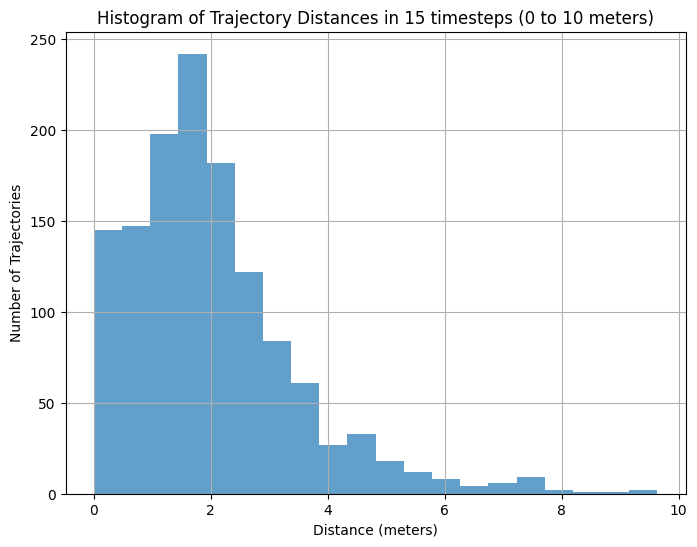

Bin 1: 0.00 to 0.50 meters, Count: 146
Bin 2: 0.50 to 1.00 meters, Count: 158
Bin 3: 1.00 to 1.50 meters, Count: 204
Bin 4: 1.50 to 2.00 meters, Count: 264
Bin 5: 2.00 to 2.50 meters, Count: 168
Bin 6: 2.50 to 3.00 meters, Count: 116
Bin 7: 3.00 to 3.50 meters, Count: 83
Bin 8: 3.50 to 4.00 meters, Count: 47
Bin 9: 4.00 to 4.50 meters, Count: 31
Bin 10: 4.50 to 5.00 meters, Count: 30
Bin 11: 5.00 to 5.50 meters, Count: 17
Bin 12: 5.50 to 6.00 meters, Count: 11
Bin 13: 6.00 to 6.50 meters, Count: 6
Bin 14: 6.50 to 7.00 meters, Count: 4
Bin 15: 7.00 to 7.50 meters, Count: 10
Bin 16: 7.50 to 8.00 meters, Count: 5
Bin 17: 8.00 to 8.50 meters, Count: 1
Bin 18: 8.50 to 9.00 meters, Count: 1
Bin 19: 9.00 to 9.50 meters, Count: 0
Bin 20: 9.50 to 10.00 meters, Count: 2


In [9]:
def calculate_trajectory_lengths(trajectories):
    """
    Calculates the Euclidean distance between the first and last point of each trajectory.
    
    :param trajectories: numpy array of shape (number_trajectories, 15,2)
    
    :returns distances for all sequences 
    """
    start_points = trajectories[:, 0, :]
    end_points = trajectories[:, -1, :]
    distances = np.linalg.norm(end_points - start_points, axis=1)
    return distances

def plot_limited_distance_histogram(distances, bins=10, distance_limit=10):
    """
    Plots a histogram of the trajectory distances limited by a maximal distance to get an overview
    over the most trajectories disregarding outliers
    
    :param distances: numpy array of trajectory distances
    :param bins: number of bins for the histogram
    :param distance_limit: maximum distance to be included in the histogram
    """
    # Filter distances to be in the range of the distance limit
    filtered_distances = distances[distances <= distance_limit]

    hist, bin_edges = np.histogram(filtered_distances, bins=bins, range=(0, distance_limit))
    
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_distances, bins=bins, alpha=0.7)
    
    plt.title(f'Histogram of Trajectory Distances in 15 timesteps (0 to {distance_limit} meters)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of Trajectories')
    plt.grid(True)
    plt.show()
    
    # Print the bin ranges and the counts
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i+1}: {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f} meters, Count: {hist[i]}")


distances = calculate_trajectory_lengths(seq)
plot_limited_distance_histogram(distances, bins=20, distance_limit=10)


In [10]:
# Get the distances from first to last positions and get the range of all trajectories, so instead of how many are in the range up
# to a specific value, get the range in which 75 or 80 percent of all trajectories are
def calculate_percentile_range(distances, percentile):
    """
    Calculates the distance range that contains up to the given percentile of the distances.
    
    :param distances: numpy array of trajectory distances
    :param percentile: percentile to calculate the distance range for
    
    :returns tuple representing the range from the minimum distance to the specified percentile distance
    """
    min_distance = np.min(distances)
    percentile_distance = np.percentile(distances, percentile)
    return (min_distance, percentile_distance)

distances = calculate_trajectory_lengths(seq)

percentile_75_range = calculate_percentile_range(distances, 75)
print(f"Range containing 75% of distances: {percentile_75_range[0]:.2f} to {percentile_75_range[1]:.2f} meters")

percentile_80_range = calculate_percentile_range(distances, 80)
print(f"Range containing 80% of distances: {percentile_80_range[0]:.2f} to {percentile_80_range[1]:.2f} meters")


Range containing 75% of distances: 0.00 to 2.71 meters
Range containing 80% of distances: 0.00 to 2.97 meters


# Visualising Individual Trajectories
Visualise multiple trajectories in a range of 10 meters around the robot (at (0,0)) to see thedifferent speeds, distances, occclusions and noise.

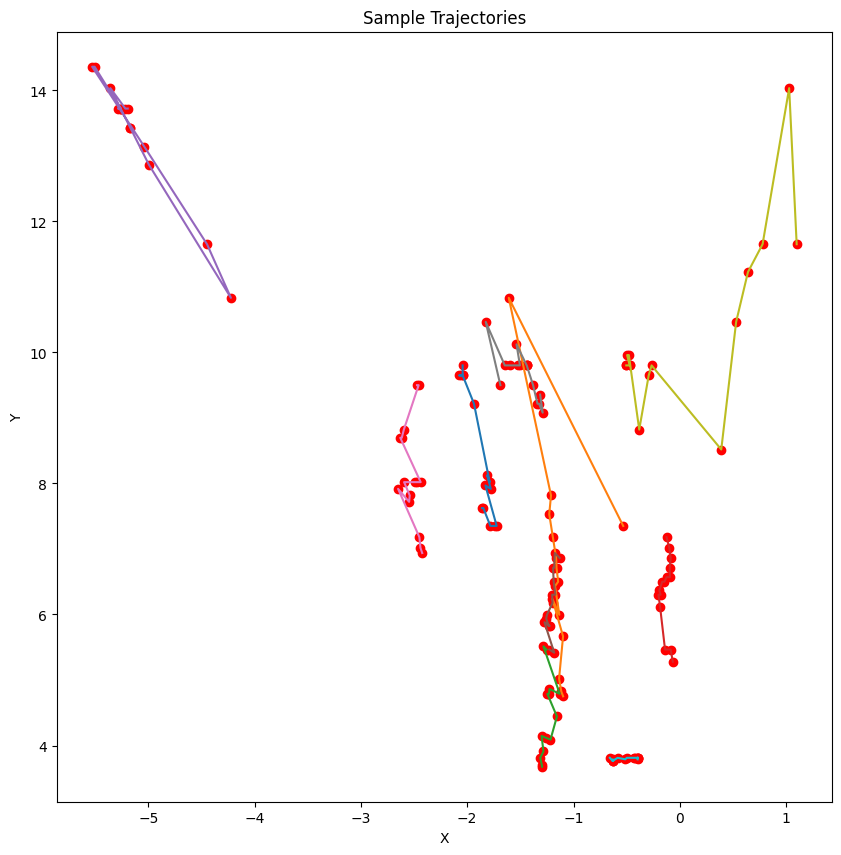

In [11]:
def plot_trajectory(trajectory, label=None):
    x, y = trajectory[:, 0], trajectory[:, 1]
    plt.plot(x, y, label=label)
    plt.scatter(x, y, c='r') 
    plt.xlabel('X')
    plt.ylabel('Y')

plt.figure(figsize=(10, 10))
for i in range(10): 
    plot_trajectory(seq[i])

plt.title('Sample Trajectories')
plt.show()


# Noise analysis
Get the npise between single steps in order to probably see how many occlusions or missing data there is, because large steps cannot be made in the given timestep

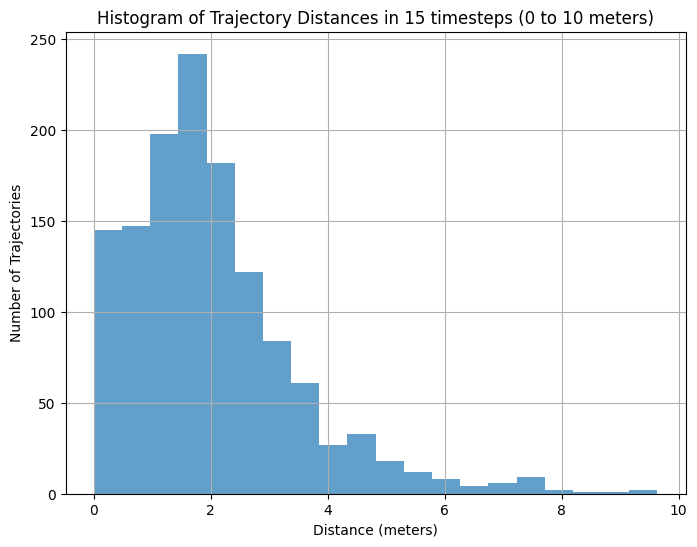

Bin 1: 0.00 to 0.50 meters, Count: 146
Bin 2: 0.50 to 1.00 meters, Count: 158
Bin 3: 1.00 to 1.50 meters, Count: 204
Bin 4: 1.50 to 2.00 meters, Count: 264
Bin 5: 2.00 to 2.50 meters, Count: 168
Bin 6: 2.50 to 3.00 meters, Count: 116
Bin 7: 3.00 to 3.50 meters, Count: 83
Bin 8: 3.50 to 4.00 meters, Count: 47
Bin 9: 4.00 to 4.50 meters, Count: 31
Bin 10: 4.50 to 5.00 meters, Count: 30
Bin 11: 5.00 to 5.50 meters, Count: 17
Bin 12: 5.50 to 6.00 meters, Count: 11
Bin 13: 6.00 to 6.50 meters, Count: 6
Bin 14: 6.50 to 7.00 meters, Count: 4
Bin 15: 7.00 to 7.50 meters, Count: 10
Bin 16: 7.50 to 8.00 meters, Count: 5
Bin 17: 8.00 to 8.50 meters, Count: 1
Bin 18: 8.50 to 9.00 meters, Count: 1
Bin 19: 9.00 to 9.50 meters, Count: 0
Bin 20: 9.50 to 10.00 meters, Count: 2


In [15]:
def calculate_noise(trajectories):
    """
    Calculates the Euclidean distance between consecutive points of each trajectory.
    
    :param trajectories: numpy array of shape (number_trajectories, 15,2)
    
    :returns distances between two following points for all sequences 
    """
        # Differences between consecutive points
    differences = np.diff(trajectories, axis=1)
    # Magnitude of these differences (Euclidean distance)
    noise_levels = np.linalg.norm(differences, axis=-1)
    return noise_levels

def plot_noise_histogram(noise, bins=10, distance_limit=10):
    """
    Plots a histogram of the trajectory noise limited by a maximal distance to get an overview
    over the most trajectories disregarding outliers
    
    :param noise: numpy array of trajectory noise
    :param bins: number of bins for the histogram
    :param distance_limit: maximum distance to be included in the histogram
    """
    # Filter noise to be in the range of the distance limit
    filtered_noise = noise[noise <= distance_limit]

    hist, bin_edges = np.histogram(filtered_noise, bins=bins, range=(0, distance_limit))
    
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_noise, bins=bins, alpha=0.7)
    
    plt.title(f'Histogram of Trajectory Distances in 15 timesteps (0 to {distance_limit} meters)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of Trajectories')
    plt.grid(True)
    plt.show()
    
    # Print the bin ranges and the counts
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i+1}: {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f} meters, Count: {hist[i]}")


noise = calculate_trajectory_lengths(seq)
plot_noise_histogram(noise, bins=20, distance_limit=10)
